In [23]:
#Import libraries:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import gc

from sklearn.svm import  OneClassSVM
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

sns.set_style('whitegrid')

In [24]:
import os
print(os.listdir("../Elo-Merchant-Category-Recommendation/"))

['Data_Dictionary.xlsx', 'test.csv', 'historical_transactions.csv', 'Elo-Merchant-Category-Recommendation.zip', 'new_merchant_transactions.csv', '.ipynb_checkpoints', 'sample_submission.csv', '.git', '.gitignore', 'LICENSE', 'train.csv', 'basic_model.py.ipynb', 'README.md', 'merchants.csv']


In [25]:
train_df = pd.read_csv('../Elo-Merchant-Category-Recommendation/train.csv')
test_df = pd.read_csv('../Elo-Merchant-Category-Recommendation/test.csv')
#df_hist_trans = pd.read_csv('../Elo-Merchant-Category-Recommendation/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('../Elo-Merchant-Category-Recommendation/new_merchant_transactions.csv')

## Basic model to test extent before advanced models

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


no missing data

In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123623 non-null object
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.7+ MB


1 data point missing

filling NAs

In [35]:
train_df['first_active_month'].value_counts()

2017-09    13878
2017-10    13695
2017-08    13638
2017-11    12930
2017-07    12363
2017-12    10170
2017-06     9930
2017-01     9605
2016-12     9403
2017-05     9168
2017-04     8761
2017-03     8271
2017-02     8110
2016-11     7222
2016-10     5371
2016-08     4977
2016-09     4410
2016-07     4188
2016-06     4102
2016-05     3314
2016-04     2938
2015-12     2343
2016-03     2005
2016-01     1711
2016-02     1636
2015-11     1582
2015-10     1532
2015-09     1494
2015-07     1393
2015-08     1376
           ...  
2014-03      242
2014-02      198
2013-12      165
2014-01      144
2013-11      132
2013-10      126
2013-08      126
2013-09      121
2013-07      110
2013-05       94
2013-06       79
2013-03       58
2013-04       58
2012-11       48
2012-09       38
2013-02       37
2012-08       36
2018-01       34
2012-10       31
2012-07       29
2012-05       28
2013-01       23
2012-06       19
2012-04       18
2012-12       18
2012-03       10
2011-11        8
2012-02       

In [38]:
test_df['first_active_month'] = test_df['first_active_month'].fillna('2018-01-01')

In [39]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


#### partition of features

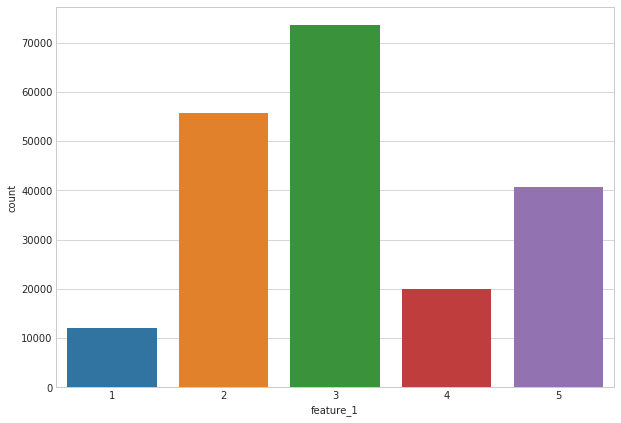

In [42]:
plt.figure(figsize=(10, 7))
sns.countplot(train_df['feature_1'])
plt.show()

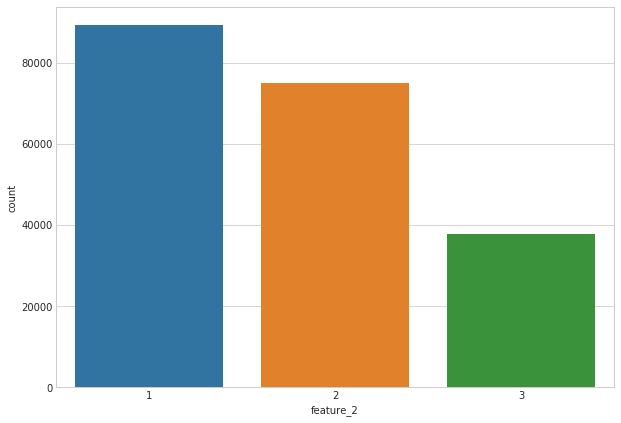

In [44]:
plt.figure(figsize=(10, 7))
sns.countplot(train_df['feature_2'])
plt.show()

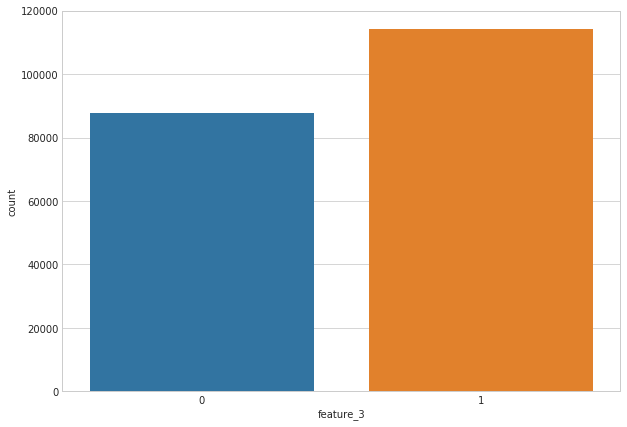

In [45]:
plt.figure(figsize=(10, 7))
sns.countplot(train_df['feature_3'])
plt.show()

Features seem pretty balanced.

#### First active month

In [46]:
train_df['first_active_month'] = pd.to_datetime(train_df['first_active_month'])
test_df['first_active_month'] = pd.to_datetime(test_df['first_active_month'])

In [48]:
train_df['first_active_month'].head()

0   2017-06-01
1   2017-01-01
2   2016-08-01
3   2017-09-01
4   2017-11-01
Name: first_active_month, dtype: datetime64[ns]

In [12]:
print("Newest client :", max( max(train_df['first_active_month']), max(test_df['first_active_month'])))

Newest client : 2018-02-01 00:00:00


In [50]:
first_active_day = pd.to_timedelta(train_df['first_active_month']).apply(lambda x: x.days)
first_active_day_test = pd.to_timedelta(test_df['first_active_month']).apply(lambda x: x.days)

In [54]:
first_active_day.head()

0    17318
1    17167
2    17014
3    17410
4    17471
Name: first_active_month, dtype: int64

In [55]:
newest = max(max(first_active_day), max(first_active_day_test))

In [57]:
newest

17563

In [58]:
ancienety = (newest - first_active_day).astype(int) // 30
ancienety_test = (newest - first_active_day_test).astype(int) // 30

<Figure size 864x576 with 0 Axes>

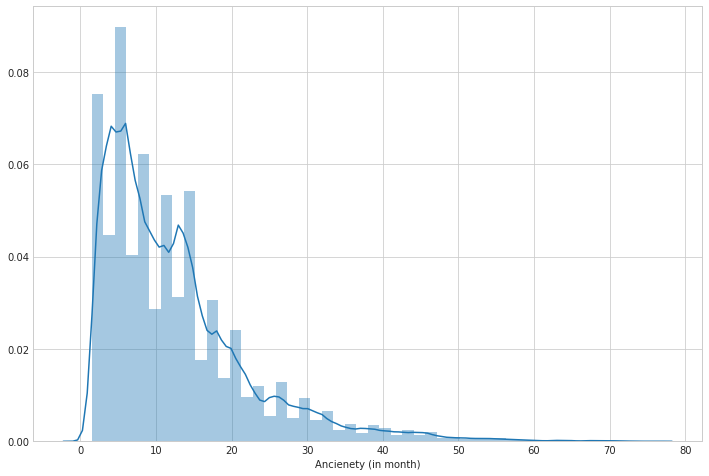

In [60]:
plt.figure(figsize=(12, 8))
sns.distplot(ancienety)
plt.xlabel('Ancienety (in month)')
plt.show()

In [ ]:
train_df['ancienety'] = ancienety
test_df['ancienety'] = ancienety_test